# Goal:

* Modeling a theoretical diffusive boundary layer (DBL). 
  * A DBL may be contributing to 'smearing' observed in 16S rRNA MiSeq data from real experiments.

# Init

In [26]:
import os
import numpy as np
from scipy.integrate import quad
%load_ext rpy2.ipython

workDir = '/home/nick/notebook/SIPSim/dev/theory/'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)
library(rootSolve)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [27]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/nick/notebook/SIPSim/dev/theory


# Setting parameters

In [3]:
%%R
# tube characteristics (cm)
tube_diam = 1.3   
tube_height = 4.8
tube_round_bottom_height = 0.65
tube_capacity__ml = 4.7
tube_composition = 'polypropylene'

# rotor (cm)
rotor_id = 'TLA-110'
r_min = 2.6
r_ave = 3.72
r_max = 4.85
frac_tube_angle = 90 

# cfg run
## rpm of run
rpm = 55000
## angular velocity (w^2)
angular_velocity = 17545933.74
## average particle density
ave_gradient_density = 1.70
## beta^o  
BetaO = 1.14e9  # CsCl at density of 1.70
## position of particle at equilibrium 
particle_at_eq = 3.78 
## max 13C shift
max_13C_shift_in_BD = 0.036
## min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
## max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD

# diffusive boundary layer (DBL)
DBL_size_range__micron = c(10,100)


# misc
fraction_vol__cm3 = 0.1

In [4]:
%%R
# rotor angle
## sin(x) = opp / hypo
## x = sin**-1(opp/hypo)

rad2deg = function(rad) {
    return((180 * rad) / pi)
}
deg2rad = function(deg){
    return(deg * pi / 180)
}


x = r_max - r_min
hyp = tube_height
rotor_tube_angle = rad2deg(asin(x / hyp))
cat("Tube angle from axis of rotation:", rotor_tube_angle, "\n")

Tube angle from axis of rotation: 27.95319 


In [5]:
%%R
rad2deg = function(rad) {
    return((180 * rad) / pi)
}
deg2rad = function(deg){
    return(deg * pi / 180)
}


x = r_max - r_min
hyp = tube_height
rotor_tube_angle = rad2deg(asin(x / hyp))
cat("Tube angle from axis of rotation:", rotor_tube_angle, "\n")

Tube angle from axis of rotation: 27.95319 


In [6]:
%%R
# calc tube angle from tube params
calc_tube_angle = function(r_min, r_max, tube_height){
    x = r_max - r_min
    hyp = tube_height
    rotor_angle = rad2deg(asin(x / hyp))
    return(rotor_angle)
    }

# test
## angled tube
ret = calc_tube_angle(r_min, r_max, tube_height)
print(ret)
## vertical tube
r_min_v = 7.47 
r_max_v = 8.79 
ret = calc_tube_angle(r_min_v, r_max_v, tube_height)
print(ret)

[1] 27.95319
[1] 15.96201


In [7]:
%%R
# isoconcentration point
## Formula 6.7 in Birnine and Rickwood 1978
I = sqrt((r_min**2 + r_min * r_max + r_max**2)/3)

cat('Isoconcentration point:', I, '(cm)\n')

Isoconcentration point: 3.781204 (cm)


# ratio of DBL size : fraction size as a function of DBL size

## Rough approximation

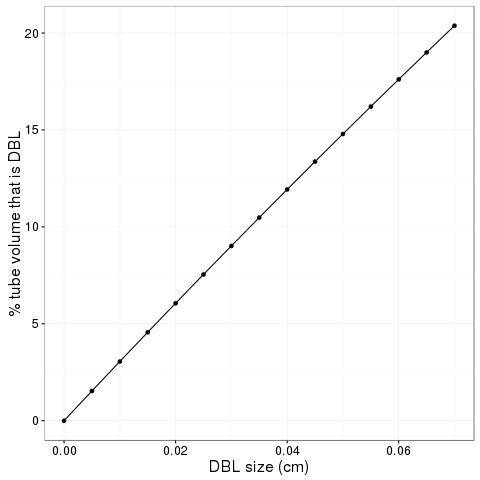

In [8]:
%%R

DBL_rel_size = function(DBL_size, tube_diam, frac_size){
    # sizes in cm
    tube_radius = tube_diam / 2
    frac_vol = pi * tube_radius**2 * frac_size
    nonDBL_vol = pi * (tube_radius - DBL_size)**2 * frac_size
    DBL_vol = frac_vol - nonDBL_vol
    DBL_to_frac = DBL_vol / frac_vol * 100
    return(DBL_to_frac)
}

# in cm
frac_size = 0.01
tube_diam = 1.3
#DBL_size = 0.01
DBL_sizes = seq(0, 0.07, 0.005)

DBL_perc = sapply(DBL_sizes, DBL_rel_size, tube_diam=tube_diam, frac_size=frac_size)

df = data.frame('DBL_size' = DBL_sizes, 'DBL_perc' = DBL_perc)

ggplot(df, aes(DBL_size, DBL_perc)) +
    geom_point() +
    geom_line() +
    labs(x='DBL size (cm)', y='% tube volume that is DBL') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* Assuming cfg tube is just a cylinder

# Determining DBL from fragment G+C content 

* fragment GC -->
  * BD (diffusive boundary layer) --> 
    * angled tube position of DBL -->
      * vertical tube position range of DBL (min, mid, max)

# Functions for calculating DBL

## GC to BD

In [9]:
%%R
GC2BD = function(GC){ 
    # GC = percent G+C
    GC / 100.0 * 0.098 + 1.66 
}

# test
GC = seq(0, 100, 10)
sapply(GC, GC2BD)

 [1] 1.6600 1.6698 1.6796 1.6894 1.6992 1.7090 1.7188 1.7286 1.7384 1.7482
[11] 1.7580


## BD to distance from the axis of rotation

\begin{align}
x = \sqrt{( ({\rho}-p_m) \frac{2B^{\circ}}{w^2}) + r_c^2}
\end{align}

In [10]:
%%R
BD2distFromAxis = function(BD, D, BetaO, w2, I){
    # converting BD to distance from axis of rotation
    # BD  = density at a given radius
    # w^2 = angular velocity
    # \beta^o = beta coef
    # I = isocencentration point (cm)
    # D = average density of gradient
    sqrt(((BD-D)*2*BetaO/w2) + I^2)
}

# test
min_BD_r = BD2distFromAxis(min_BD, ave_gradient_density, BetaO, angular_velocity, I)
max_BD_r = BD2distFromAxis(max_BD, ave_gradient_density, BetaO, angular_velocity, I)

cat('radius range for BD-min to BD-max: ', min_BD_r, 'to', max_BD_r, '\n')

radius range for BD-min to BD-max:  3.289207 to 4.895445 


## distance from axis of rotation to tube height of BD 'band' 

* The band is angled in the tube, so the BD band in the gradient (angled tube) will touch the wall of the tube at a min/max height of h1 and h2. This function determines those tube height values.

\begin{align}
    y_t = 
\end{align}

* x = a distance from the axis of rotation
* r = radius of cfg tube
* D = max tube distance from axis of rotation
* A = angle of tube to axis of rotation (degrees)

In [13]:
%%R

distFromAxis2angledTubePos = function(x, r, D, A){
  # converting distance from axis of rotation to cfg tube position (min & max of tube height)
  # x = a distance from the axis of rotation
  # r = radius of cfg tube
  # D = max tube distance from axis of rotation
  # A = angle of tube to axis of rotation (degrees)
  
  # Equation for finding the lower point of the band  
  if(x >= D-(r*aspace::cos_d(A))-r) {
    d = x-(D-r)
    a = A-aspace::asin_d(d/r)
    LowH = r-r*aspace::cos_d(a)
    #print(LowH)                ## This band will be in the rounded part
  }else{
    d = D-(r*aspace::cos_d(A))-r-x
    hc = d/aspace::sin_d(A)
    LowH = r+hc
  # print(LowH)                 ## This band will be in the cylinder part
  }

  # Equation for finding the upper band
  if(x > D-(r-r*aspace::cos_d(A))) {
    d = x-(D-r)
    a = (A)-(180-aspace::asin_d(d/r))
    HighH = r-r*aspace::cos_d(a)
    #print(HighH)                ## This band will be in the rounded part
  }else{
    d = D-(r-r*aspace::cos_d(A))-x
  hc = d/aspace::sin_d(A)
  HighH = r+hc
  #print(HighH)                ## This band will be in the cylinder part
  }
  
  return(c(LowH, HighH))
}


# test
r = 0.65   # radius of tube (cm)
D = 4.85   # distance from axis of rotation to furthest part of tube (cm)
A = 27.95  # angle of tube to axis of rotation (degrees)
x = 3.5    # some distance from axis of rotation (from equation)

pos = distFromAxis2angledTubePos(x, r, D, A)
pos %>% print
delta = pos[2] - pos[1]
delta %>% print

[1] 0.9184398 3.3685399
[1] 2.4501


### Python version

In [14]:
sin_d = lambda d : np.sin(np.deg2rad(d))    
cos_d = lambda d : np.cos(np.deg2rad(d))    
asin_d = lambda x : np.arcsin(x) * 180/np.pi  #np.arcsin(np.deg2rad(d))
acos_d = lambda x : np.arccos(x) * 180/np.pi  #np.arccos(np.deg2rad(d))

def axisDist2angledTubePos(x, tube_radius, r_max, A):
    if np.isnan(x):
        return (x, x)
    
    if(x >= r_max - (tube_radius * cos_d(A)) - tube_radius):
        # band in rounded bottom of cfg tube
        d = x - (r_max - tube_radius)
        a = A - asin_d(d / tube_radius)
        LowH = tube_radius - tube_radius * cos_d(a)
        #print LowH
    else:
        # band in cylinder of cfg tube
        d = r_max - (tube_radius * cos_d(A)) - tube_radius - x
        h_c = d/sin_d(A)
        LowH = tube_radius + h_c
        # print LowH
    
    if(x > r_max - (tube_radius - tube_radius * cos_d(A))):
        # Equation for finding the upper band
        d = x - (r_max - tube_radius)
        a = A - (180 - asin_d(d/tube_radius))
        HighH = tube_radius - tube_radius * cos_d(a)
        #print HighH
    else:
        # This band will be in the cylinder part
        d = r_max - (tube_radius - tube_radius * cos_d(A)) - x
        h_c = d/sin_d(A)
        HighH = tube_radius + h_c
        #print(HighH)
    return(LowH, HighH)

# test
r = 0.65   # radius of tube (cm)
D = 4.85   # distance from axis of rotation to furthest part of tube (cm)
A = 27.95  # angle of tube to axis of rotation (degrees)
x = 3.5    # some distance from axis of rotation (from equation)

ret = axisDist2angledTubePos(x, r, D, A)
print(ret)
delta = ret[1] - ret[0]
print(delta)

(0.91843983608861524, 3.3685399170895249)
2.450100081


## Converting distance from axis of rotation to angled tube volume

### Python

In [15]:
def _SphVol(t, r, p2, R12):                     
    # helper function for axisDist2angledTubeVol
    v1 = t*((2*r)-t)/2                          
    v2 = 2*np.pi*((p2-t)/R12)                   
    v3 = np.sin(2*np.pi*((p2-t)/R12))           
    return v1 * (v2 - v3)                       
                                                
def _CylWedVol(t, r, b, h):                     
    # helper function for axisDist2angledTubeVol
    return 2*(h*(t-r+b)/ b) * np.sqrt(r**2-t**2)

def axisDist2angledTubeVol(x, r, D, A):
    """Convert distance from axis of rotation to volume of gradient
    where the BD is >= to the provided BD.

    Parameters
    ----------
    x : float
        distance from axis of rotation (cm)
    r : float
        cfg tube radius (cm)
    D : float
        max distance from axis of rotation (cm)
    A : float
        cdf tube angle in rotor (degrees)

    Returns
    -------
    volume (ml) occupied by gradient heavier or as heavy as at that point.
    Note: nan returned if x = nan
    """
    # return nan if nan provided
    if np.isnan(x):
        return x

    a = np.deg2rad(A)
    p1 = r-(r*np.cos(a))
    p2 = r+(r*np.cos(a))
    R12 = p2-p1
    d = D-x
    D1 = D-p1
    D2 = D-p2
    
    if x < D2:
        if a == 0:
            z = 1
        else: 
            z = np.sin(a)
        h1 = (D2-x)/z
        h2 = (D1-x)/z
        volume1 = (2/3.0)*np.pi*r**3
        volume2 = (0.5)*np.pi*r**2*(h1+h2)
        volume = volume1+volume2
    elif D1 >= x >= D2:
        volume1 = (1/3.0)*np.pi*p1**2*(3*r-p1)
        volume2 = quad(_SphVol, p1, d, args=(r, p2, R12))
        b = (d-p1)/np.cos(a)
        if a == 0:
            h = b
        else:
            h = b/np.tan(a)
        volume3 = quad(_CylWedVol, r-b, r, args=(r, b, h))
        volume = volume1+volume2[0]+volume3[0]
    elif D >= x > D1:
        volume = (1/3.0)*np.pi*d**2*(3*r-d)
    elif x > D:
        volume = np.nan
    else:
        volume = np.nan

    # status
    if np.isnan(volume):
        lmsg = 'axisDist2angledTubeVol: nan returned for x value: {}\n'
        sys.stderr.write(lmsg.format(x))

    return volume


# test
## fixed-angle rotor
r = 0.65   # radius of tube (cm)
D = 4.85   # distance from axis of rotation to furthest part of tube
A = 27.95  # angle of tube to axis of rotation (degrees)
x = 3.5    # some distance from axis of rotation (from equation)

ret = axisDist2angledTubeVol(x, r, D, A)
print(ret)


## vertical rotor
#x = 7.66
x = 8.5
r = 0.65
D = 8.79
A = 0

ret = axisDist2angledTubeVol(x, r, D, A)
print(ret)

2.55751656335
0.168563196908


## Converting tube volume to vertical tube height

### Python

In [16]:
# converting cylinder volume to height
def cylVol2height(v, r): 
    # v = volume (ml)
    # r = tube radius (cm)
    h = v / (np.pi * r**2)
    return h

# test
cylVol2height(0.1, 0.65)

0.07533961803166643

In [17]:
# converting sphere cap volume to sphere height
from scipy import optimize
def sphereCapVol2height(v, r):
    # v = volume (ml)
    # r = tube radius (cm)
    # h**3 - 3*r*h**2 + (3v / pi) = 0
    f = lambda x : x**3 - 3*r*x**2 + 3*v/np.pi
    try:
        root = optimize.brentq(f, 0, r*2, maxiter=1000)
    except ValueError:
        msg = 'WARNING: not roots for volume {}\n'
        sys.stderr.write(msg.format(v))
        root = np.nan
    return(root)

# test
sphereCapVol2heightV = np.vectorize(sphereCapVol2height)
heights = np.arange(0, 0.65**2, 0.1)
sphereCapVol2heightV(heights, 0.65)

array([ 0.        ,  0.23603985,  0.34495023,  0.43482548,  0.51613246])

In [18]:
# convert liquid volume in vertical cfg tube to tube height
def tubeVol2height(v, r):
    # v = volume (ml)
    # r = tube radius (cm)
    sphere_cap_vol = (4/3 * np.pi * r**3)/2
    
    if v <= sphere_cap_vol:
        # height does not extend to cylinder
        h = sphereCapVol2height(v, r)
    else:
        # height = sphere_cap + cylinder
        sphere_cap_height = sphereCapVol2height(sphere_cap_vol, r)
        h =  sphere_cap_height + cylVol2height(v - sphere_cap_vol, r)

    return(h)


# test
vol = 0.1   # 100 ul
vols = np.arange(0, 4+vol, vol)
tubeVol2heightV = np.vectorize(tubeVol2height)
tubeVol2heightV(vols, r=0.65)

array([ 0.        ,  0.23603985,  0.34495023,  0.43482548,  0.51613246,
        0.59233273,  0.66767235,  0.74301197,  0.81835158,  0.8936912 ,
        0.96903082,  1.04437044,  1.11971006,  1.19504967,  1.27038929,
        1.34572891,  1.42106853,  1.49640815,  1.57174776,  1.64708738,
        1.722427  ,  1.79776662,  1.87310624,  1.94844585,  2.02378547,
        2.09912509,  2.17446471,  2.24980433,  2.32514394,  2.40048356,
        2.47582318,  2.5511628 ,  2.62650242,  2.70184203,  2.77718165,
        2.85252127,  2.92786089,  3.00320051,  3.07854012,  3.15387974,
        3.22921936])

# Test run of SIPSim DBL

## Angled rotor

In [19]:
runDir = '/home/nick/notebook/SIPSim/t/genome100/'
!cd $runDir; \
    SIPSim DBL \
        --np 4 \
        ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
        > ampFrag_skewN90-25-n5-nS_dif_DBL_kde.pkl 

DBL_index file written: "DBL_index.txt"
Processing: Nocardia_nova_SH22a
Processing: Myxococcus_stipitatus_DSM_14675
Processing: Bradyrhizobium_diazoefficiens_USDA_110
Processing: Vibrio_furnissii_NCTC_11218
Processing: Sulfurihydrogenibium_azorense_Az-Fu1
Processing: Kangiella_koreensis_DSM_16069
Processing: Haemophilus_influenzae_PittEE
Processing: Aeromonas_salmonicida_subsp_salmonicida_A449
Processing: Mycobacterium_abscessus_subsp_bolletii_50594
Processing: Aeromonas_veronii_B565
Processing: Spiroplasma_culicicola_AES-1
Processing: Geobacillus_thermoleovorans_CCB_US3_UF5
Processing: Oceanithermus_profundus_DSM_14977
Processing: Thermincola_potens_JR
Processing: Capnocytophaga_canimorsus_Cc5
Processing: Planktomarina_temperata_RCA23
Processing: Leptospira_borgpetersenii_serovar_Hardjo-bovis_str_L550
Processing: Dehalogenimonas_lykanthroporepellens_BL-DC-9
Processing: Mycoplasma_bovoculi_M165_69
Processing: Candidatus_Liberibacter_asiaticus_str_Ishi-1
Processing: Kosmotoga_olearia_TB

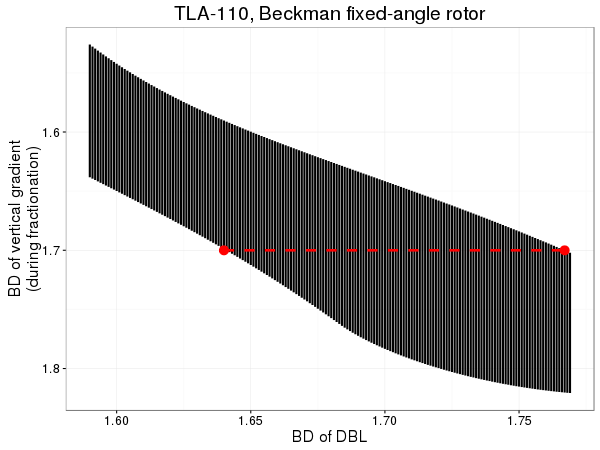

In [28]:
%%R -w 600 -h 450
inFile = '/home/nick/notebook/SIPSim/t/genome100/DBL_index.txt'
df = read.delim(inFile, sep='\t') %>%
    gather(pos, vert_grad_BD, vert_gradient_BD_low, vert_gradient_BD_high)

# example
df.ex = data.frame('DBL_BD' = c(1.64, 1.767), 'vert_grad_BD' = c(1.7, 1.7))

# plot
p.TLA = ggplot(df, aes(DBL_BD, vert_grad_BD, color=pos, group=DBL_BD)) +
    geom_line(color='black', size=1) +
    geom_point(data=df.ex, color='red', size=4) +
    geom_line(data=df.ex, aes(group=vert_grad_BD), color='red', linetype='dashed', size=1.2) +
    #geom_vline(xintercept=1.774, linetype='dashed', alpha=0.5, color='blue') +  # theoretical max fragment BD
    scale_y_reverse() +
    labs(x='BD of DBL', 
         y='BD of vertical gradient\n(during fractionation)',
         title='TLA-110, Beckman fixed-angle rotor') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.TLA

In [31]:
%%R -i workDir
# saving figure
F = file.path(workDir, 'DBL_TLA110.pdf')
ggsave(F, p.TLA, width=6, height=4.5)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/theory//DBL_TLA110.pdf 


#### Notes

* The dashed line provides an example of the 'true' BD of fragments contained in the DBL at the gradient density of 1.7 when the gradient is in the vertically oriented during fractionation.

## Vertical rotor

* VTi 65.2, Beckman rotor
  * Refs:
    * >http://www.nature.com/ismej/journal/v1/n6/full/ismej200765a.html
    * >Neufeld JD, Vohra J, Dumont MG, Lueders T, Manefield M, Friedrich MW, et al. (2007). DNA stable-isotope probing. Nat Protocols 2: 860–866.
  * params:
    * tube width = 1.3 cm
    * tube height = 5.1 cm
    * tube volume = 5.1 ml
    * r_min = 7.47 cm
    * r_max = 8.79 cm
    * final density = 1.725
    * speed = 177000 g_av (42500 rpm)
    * angular velocity = $((2 * 3.14159 * R)/60)^2$ = 19807714
    * time = 40 hr

In [32]:
runDir = '/home/nick/notebook/SIPSim/t/genome100/'
!cd $runDir; \
    SIPSim DBL \
        -D 1.725 \
        -w 19807714 \
        --tube_height 5.1 \
        --r_min 7.47 \
        --r_max 8.79 \
        --vertical \
        --np 4 \
        ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
        > ampFrag_skewN90-25-n5-nS_dif_DBL_kde_VERT.pkl 

DBL_index file written: "DBL_index.txt"
Processing: Nocardia_nova_SH22a
Processing: Myxococcus_stipitatus_DSM_14675
Processing: Aeromonas_salmonicida_subsp_salmonicida_A449
Processing: Bradyrhizobium_diazoefficiens_USDA_110
Processing: Sulfurihydrogenibium_azorense_Az-Fu1
Processing: Geobacillus_thermoleovorans_CCB_US3_UF5
Processing: Vibrio_furnissii_NCTC_11218
Processing: Kangiella_koreensis_DSM_16069
Processing: Spiroplasma_culicicola_AES-1
Processing: Thermincola_potens_JR
Processing: Haemophilus_influenzae_PittEE
Processing: Mycobacterium_abscessus_subsp_bolletii_50594
Processing: Oceanithermus_profundus_DSM_14977
Processing: Mycoplasma_bovoculi_M165_69
Processing: Aeromonas_veronii_B565
Processing: Capnocytophaga_canimorsus_Cc5
Processing: Leptospira_borgpetersenii_serovar_Hardjo-bovis_str_L550
Processing: Mycoplasma_yeatsii_GM274B
Processing: Planktomarina_temperata_RCA23
Processing: Dehalogenimonas_lykanthroporepellens_BL-DC-9
Processing: Kosmotoga_olearia_TBF_19_5_1
Processing

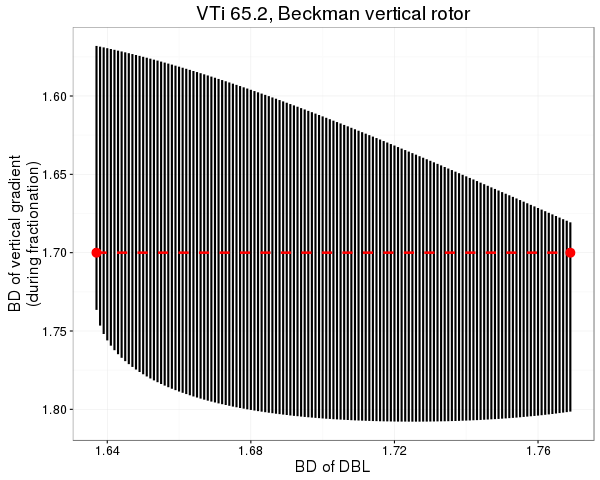

In [34]:
%%R -w 600
inFile = '/home/nick/notebook/SIPSim/t/genome100/DBL_index.txt'
df = read.delim(inFile, sep='\t') %>%
    gather(pos, vert_grad_BD, vert_gradient_BD_low, vert_gradient_BD_high)

# example
df.ex = data.frame('DBL_BD' = c(1.637, 1.769), 'vert_grad_BD' = c(1.7, 1.7))

# plot
p.VTi = ggplot(df, aes(DBL_BD, vert_grad_BD, color=pos, group=DBL_BD)) +
    geom_line(color='black', size=1) +
    geom_point(data=df.ex, color='red', size=4) +
    geom_line(data=df.ex, aes(group=vert_grad_BD), color='red', linetype='dashed', size=1.2) +
    scale_y_reverse() +
    labs(x='BD of DBL', y='BD of vertical gradient\n(during fractionation)', 
         title='VTi 65.2, Beckman vertical rotor') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.VTi

In [36]:
%%R -i workDir
# saving figure
F = file.path(workDir, 'DBL_VTi65.2.pdf')
ggsave(F, p.VTi, width=6, height=4.5)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/theory//DBL_VTi65.2.pdf 


#### Notes

* The dashed line provides an example of the 'true' BD of fragments contained in the DBL at the gradient density of 1.7 when the gradient is in the vertically oriented during fractionation.
* WARNING: the DBL simulation makes the simplifying assumption of a 2d tube object and finds the vertical distance that a band spans in the tube, which sets the span of DBL contamination in a fixed-angle rotor. However, for vertical tubes, the DBL would probably be more accurately modeled from a 3d representation of the tube.
  * Regardless, there would be substantially more DBL 'smearing' with a vertical rotor than a fixed-angle rotor.

***
# Misc

## DNA diffusion

* sedimentation coefficient of DNA (S)
  * $S = 2.8 + (0.00834 * M^{0.479})$
    * where
      * M = molecular weight of DNA
  * OR $S = 2.8 + (0.00834 * (L*666)^{0.479})$
    * where
      * L = length of DNA
* Svedberg's equation
  * $s/D = \frac{M(1-\bar{V}p)}{RT}$
  * where
    * s = sedimentation coefficient
    * D = diffusion coefficient
    * M = molecular weight
    * $\bar{V} = 1/\rho_p$
      * $\rho_p$ = density of the sphere
    * p = density of the liquid
    * R = universal gas constant
    * T = absolute temperature
* Finding diffusion coefficient of DNA in CsCl ($\mu m^2 / s$)
  * $D = \frac{RT}{M(1-\bar{V}p)}*s$
    * where
      * R = 8.3144598 (J mol^-1 K^-1)
      * T = 293.15 (K)
      * p = 1.7  (Buckley lab gradients)
      * $\bar{V} = 1/\rho_p$
        * $\rho_p$ = 1.99 
      * $s = 2.8 + (0.00834 * (L*666)^{0.479})$
        * L = DNA length (bp)


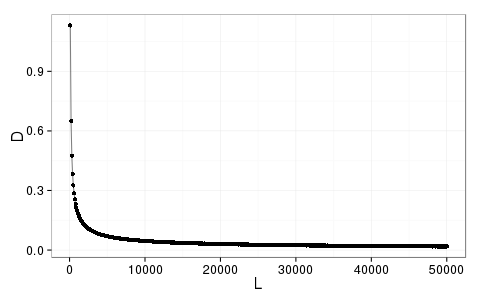

In [13]:
%%R -h 300

length2MW = function(L){ L * 666 }

length2sedCoef = function(L){
    2.8 + (0.00834 * (L*666)**0.479)
}

MW2diffuseCoef = function(L, p, R=8.3144598, T=293.15){
    V = 1/1.99
    M = length2MW(L)
    s = length2sedCoef(L)
    (R*T)/(M*(1-V*p)) * s
}

# test
L = seq(100, 50000, 100)
p = 1.7
D = sapply(L, MW2diffuseCoef, p=p)
df = data.frame('L' = L, 'D' = D)


# plotting
ggplot(df, aes(L, D)) +
    geom_point() +
    geom_line(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Calculating diffusion from DBL

* Einstein-Smoluchowski relation
  * $t = \frac{z^2}{0.9 * D}$
    * where
      * t = time (sec)
      * z = mean deviation of molecules from starting position
      * D = diffusion coefficient (cm^2 s^-1)
  * rewritten: $z = \sqrt{0.9*D*t}$

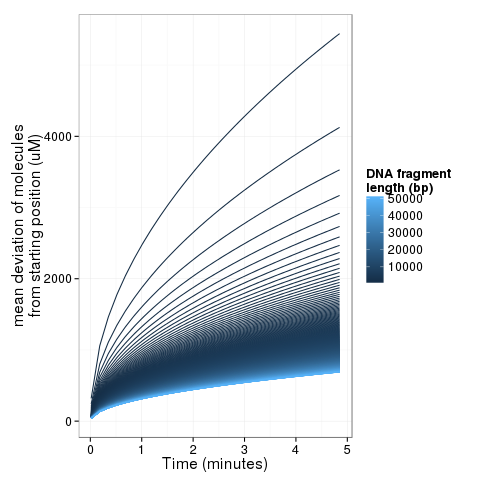

In [54]:
%%R

# converting D to cm^2/s
df$D_cm = df$D * 1e-5

# time periods (sec)
t = seq(1, 300, 10) 

# calculating z (cm)
ES = function(D, t){
    sqrt(0.9 * D * t)
}
df2 = expand.grid(df$D_cm, t)
colnames(df2) = c('D_cm', 't')
df2$z = mapply(ES, df2$D_cm, df2$t)
tmp = expand.grid(df$L, t)

# adding variable
df2$L = tmp$Var1
df2$t_min = df2$t / 60
df2$z_uM = df2$z / 1e-5

## plotting
ggplot(df2, aes(t_min, z_uM, color=L, group=L)) +
    #geom_point(size=1.5) +
    geom_line() +
    labs(x='Time (minutes)', 
         y='mean deviation of molecules\nfrom starting position (uM)') +
    scale_color_continuous('DNA fragment\nlength (bp)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

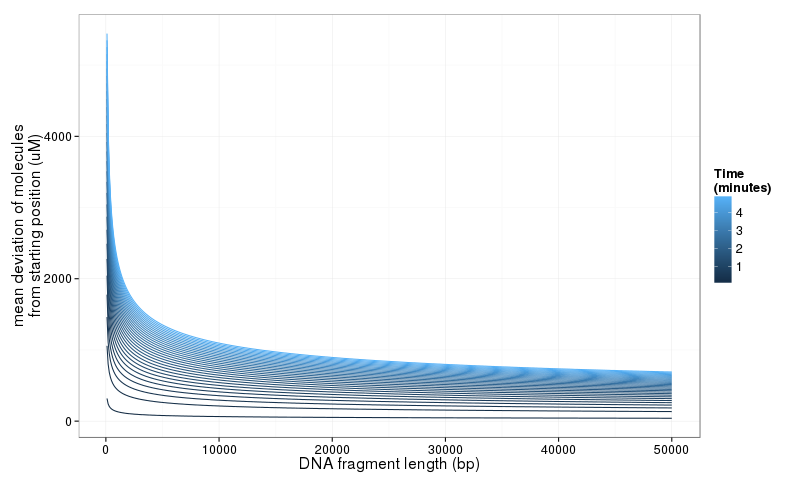

In [55]:
%%R -w 800
## plotting
ggplot(df2, aes(L, z_uM, color=t_min, group=t_min)) +
    #geom_point(size=1.5) +
    geom_line() +
    labs(x='DNA fragment length (bp)', 
         y='mean deviation of molecules\nfrom starting position (uM)') +
    scale_color_continuous('Time\n(minutes)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )